In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install timm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from timm.models.layers.adaptive_avgmax_pool import SelectAdaptivePool2d
from torch.nn import Flatten

from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.callback.fp16 import *

#import pydicom
#!pip install -qU python-gdcm pydicom pylibjpeg

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.3 MB/s eta 0:00:0000:0100:01


In [2]:
df_org = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
df_org.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets, stratified by the "target" column
df, test_df = train_test_split(df_org, test_size=0.2, stratify=df_org['cancer'], random_state=1)
print('shape of train_df', df.shape)
print('shape of test_df', test_df.shape)

shape of train_df (43764, 14)
shape of test_df (10942, 14)


In [4]:
df['filepath'] = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/' + df['patient_id'].astype(str) + '/' + df['image_id'].astype(str) + '.png'
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,filepath
18045,2,29045,1368162701,L,MLO,59.0,0,0,0,NaN,0,NaN,21,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/29045/1368162701.png
30611,2,42723,393602038,L,MLO,64.0,0,0,0,NaN,0,NaN,29,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/42723/393602038.png
35841,2,48437,2019927981,R,CC,58.0,1,1,1,NaN,0,NaN,48,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/48437/2019927981.png
16701,2,27691,1879435969,L,MLO,73.0,0,0,0,NaN,0,NaN,21,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/27691/1879435969.png
15691,1,26700,88710137,R,CC,54.0,1,1,1,0.0,0,D,49,False,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/26700/88710137.png


In [5]:
df.iloc[0,-1]

'/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/29045/1368162701.png'

In [6]:
df.density.value_counts()

B    10105
C     9712
A     2484
D     1241
Name: density, dtype: int64

In [7]:
df = df[['filepath', 'cancer']]
df.head()

,filepath,cancer
18045,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/29045/1368162701.png,0
30611,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/42723/393602038.png,0
35841,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/48437/2019927981.png,1
16701,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/27691/1879435969.png,0
15691,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/26700/88710137.png,1


In [8]:
df.cancer.value_counts()

0    42838
1      926
Name: cancer, dtype: int64

# Training

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets, stratified by the "target" column
df1, df2 = train_test_split(df, test_size=0.2, stratify=df['cancer'], random_state=1)
print('shape of train_df', df1.shape)
print('shape of val_df', df2.shape)

shape of train_df (35011, 2)
shape of val_df (8753, 2)


In [11]:
df1['valid']=False
df2['valid']=True

In [12]:
dfcon = pd.concat([df1, df2], ignore_index=True, axis=0)
dfcon.head()

,filepath,cancer,valid
0,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/7649/1197801657.png,0,False
1,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/62560/757717984.png,0,False
2,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/49827/1511177902.png,0,False
3,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/57525/550007476.png,1,False
4,/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_512/train_images_processed_cv2_512/31931/2127613140.png,0,False


In [13]:
def get_x(r):
    return r[0]

def get_y(r):
    return r[1]

In [ ]:
def get_split(r):
        return r[2]

In [19]:
db = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                   get_x=get_x,#lambda x:x[0],
                   get_y=get_y,#lambda x:x[1],
                   splitter  = RandomSplitter(seed=1))

dls = db.dataloaders(df.values, num_workers=0, bs=32)

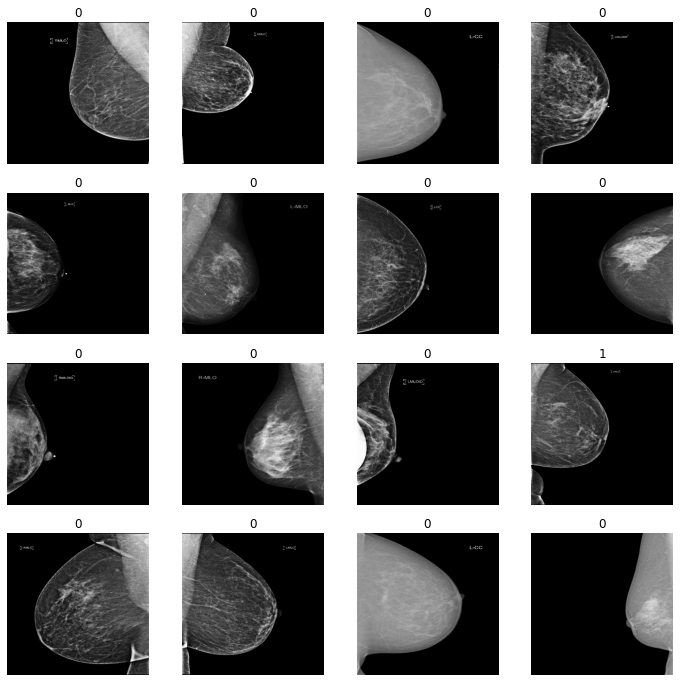

In [20]:
dls.show_batch(max_n=16)

In [21]:
def get_learner(arch=resnet18):
    learner = vision_learner(
        dls,
        arch,
        custom_head=nn.Sequential(SelectAdaptivePool2d(pool_type='avg', flatten=Flatten()), nn.Linear(1280, 2)),
        metrics=[
            error_rate,
            accuracy,
            F1Score()
        ],
        #loss_func=CrossEntropyLossFlat(weight=torch.tensor([1,20]).float()),
        loss_func=FocalLossFlat(gamma=2),
        pretrained=True,
        #normalize=False
    ).to_fp16()
    return learner

In [22]:
learn = get_learner('tf_efficientnetv2_s')

In [23]:
#learn.summary()

In [24]:
#learn = vision_learner(dls, resnet18, metrics=error_rate).to_fp16()

In [25]:
learn.loss_func

FlattenedLoss of FocalLoss()

In [ ]:
#learn.lr_find()

In [26]:
# learn.unfreeze()
learn.fit_one_cycle(6, 0.001)

epoch,train_loss,valid_loss,error_rate,accuracy,f1_score,time


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_sched()

In [ ]:
#learn.lr_find()

In [ ]:
#learn.fit_one_cycle(6, 0.0006)

In [ ]:
#learn.unfreeze()

In [ ]:
#learn.lr_find()

In [ ]:
#learn.fit_one_cycle(6, 1e-5)

In [ ]:
#learn.recorder.plot_sched()

In [ ]:
#learn.activation_stats.plot_layer_stats(0)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('flw50_512_ch_enetv2_s_ft', with_opt=False)

# Validation Data Metric

In [ ]:
# # # interp = ClassificationInterpretation.from_learner(learn)
# # # losses,idxs = interp.top_losses()
# # # len(dls.valid_ds)==len(losses)==len(idxs)
# # # interp.plot_confusion_matrix(figsize=(7,7))

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
#interp.plot_top_losses(5, nrows=1)